In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("PySpark App") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.sql.execution.arrow.enabled", "false") \
    .getOrCreate()


.appName("PySpark App") \  (name is displayed in the Spark UI and logs, helping to identify your application)
.config("spark.executor.memory", "4g") \ (Allocates 4 GB of memory for each Spark executor.Executors are processes running on worker nodes in the Spark cluster)
.config("spark.driver.memory", "4g") \ (4 GB of memory for the driver program. manages the execution of Spark jobs and interacts with the user)
.config("spark.executor.cores", "4") \ ( 4 CPU cores to each executor. determines how many parallel tasks each executor can run simultaneously.)
 .config("spark.sql.execution.arrow.enabled", "false") \ ( Apache Arrow for data exchange between PySpark and Pandas.)

### Importing Dataset in chunks

In [2]:
from pyspark import StorageLevel

# Load data directly into partitions
data = spark.read.csv("processedTaxiDataset.csv", header=True, inferSchema=True)
data = data.repartition(200)  # Adjust the number of partitions for parallelism

data = data.persist(StorageLevel.MEMORY_AND_DISK)


In [24]:
# Display schema
data.printSchema()

# Show sample rows
data.show(5)

# Count the number of rows
data.count()


root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: double (nullable = true)
 |-- DOLocationID: double (nullable = true)
 |-- payment_type: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- PULatitude: double (nullable = true)
 |-- PULongitude: double (nullable = true)
 |-- DOLatitude: double (nullable = true)
 |-- DOLongitude: double (nullable = true)

+--------

11916667

### Numerical Statistics for the Data

In [3]:
# Summary statistics for numerical columns
data.describe().show()

+-------+--------------------+--------------------+---------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+-----------------+------------------+---------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|summary|            VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|   passenger_count|     trip_distance|        RatecodeID|store_and_fwd_flag|      PULocationID|      DOLocationID|       payment_type|       fare_amount|             extra|            mta_tax|       tip_amount|      tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|          PULatitude|         PULongitude|          DOLatitude|         DOLongitude|
+-------+--------------------+--------------------+---------------------+------------------+----------

### Handling negative values
Checking and removing the negative values

In [6]:
# Check rows with negative values in specific columns
negative_values = data.filter(
    (data.trip_distance < 0) |
    (data.total_amount < 0) |
    (data.tolls_amount < 0) |
    (data.fare_amount < 0) |
    (data.extra < 0) |
    (data.mta_tax < 0) |
    (data.tip_amount < 0) |
    (data.improvement_surcharge < 0) 
)
negative_values.show()

# Count rows with negative values
negative_values_count = negative_values.count()
print(f"Number of rows with negative values: {negative_values_count}")


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+------------------+------------------+------------------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|        PULatitude|       PULongitude|        DOLatitude|       DOLongitude|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+------------------+------------------+------------------+---------------

In [7]:
cleaned_data = data.filter(
    (data.trip_distance >= 0) &
    (data.total_amount >= 0) &
    (data.tolls_amount >= 0) &
    (data.fare_amount >= 0) &
    (data.extra >= 0) &
    (data.mta_tax >= 0) &
    (data.tip_amount >= 0) &
    (data.improvement_surcharge >= 0) &
    (data.PULatitude >= 0) & (data.PULongitude >= -180) &
    (data.DOLatitude >= 0) & (data.DOLongitude >= -180)
)


In [7]:
print(f"Row count before filtering: {data.count()}")
print(f"Row count after filtering: {cleaned_data.count()}")


Row count before filtering: 11916667
Row count after filtering: 11749658


In [30]:
cleaned_data.describe().show()


+-------+-------------------+--------------------+---------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-------------------+------------------+------------------+-------------------+------------------+-------------------+---------------------+------------------+--------------------+--------------------+-------------------+-------------------+--------------------+
|summary|           VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|   passenger_count|     trip_distance|        RatecodeID|store_and_fwd_flag|      PULocationID|     DOLocationID|       payment_type|       fare_amount|             extra|            mta_tax|        tip_amount|       tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|          PULatitude|        PULongitude|         DOLatitude|         DOLongitude|
+-------+-------------------+--------------------+---------------------+------------------+---------------

### Count null values in each column

In [35]:
# Count null values in each column
from pyspark.sql.functions import col, isnull, when, count

cleaned_data.select([count(when(isnull(c), c)).alias(c) for c in cleaned_data.columns]).show()

# Unique value count for each column
cleaned_data.select([count(col(c)).alias(f"{c}_unique") for c in cleaned_data.columns]).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+----------+-----------+----------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|PULatitude|PULongitude|DOLatitude|DOLongitude|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+----------+-----------+----------+-----------+
|   88290|                   0|                    0|          88290|            0|  

In [8]:
from pyspark.sql.types import DoubleType
from pyspark.sql import functions as F
from pyspark.sql.functions import to_timestamp, col, count, when, mean, stddev, max, min, hour, dayofweek, month, year

mean_values = {col_name: cleaned_data.select(mean(col(col_name))).collect()[0][0] for col_name in cleaned_data.columns if cleaned_data.schema[col_name].dataType == DoubleType()}
cleaned_data = cleaned_data.fillna(mean_values)

In [9]:
columns_to_drop = ["store_and_fwd_flag"]
cleaned_data = cleaned_data.drop(*columns_to_drop)


In [11]:
# Percentage of missing values
total_rows = cleaned_data.count()
missing_percentage = cleaned_data.select(
    [(F.count(when(col(c).isNull(), c)) / total_rows * 100).alias(c) for c in cleaned_data.columns]
)
missing_percentage.show()

+------------------+--------------------+---------------------+---------------+-------------+----------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+----------+-----------+----------+-----------+
|          VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|PULatitude|PULongitude|DOLatitude|DOLongitude|
+------------------+--------------------+---------------------+---------------+-------------+----------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+----------+-----------+----------+-----------+
|0.7514261266157705|                 0.0|                  0.0|            0.0|          0.0|       0.0|        

## Outliar Detection and Removal

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, expr

# Step 1: Identify Numerical Columns
numerical_cols = [c for c, t in cleaned_data.dtypes if t in ['double', 'int']]


In [12]:
# Step 2: Remove Outliers Using IQR Method
def remove_outliers(df, col_name):
    # Calculate Q1, Q3, and IQR
    quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0.01)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out rows with outliers
    return df.filter((col(col_name) >= lower_bound) & (col(col_name) <= upper_bound))

# Apply outlier removal to all numerical columns
filtered_data = cleaned_data
for col_name in numerical_cols:
    filtered_data = remove_outliers(filtered_data, col_name)



In [14]:
print(f"Row count after filtering: {filtered_data.count()}")

Row count after filtering: 6454596


## Converting time column

In [13]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
from pyspark.sql.functions import to_timestamp

filtered_data = filtered_data.withColumn("tpep_pickup_datetime", to_timestamp("tpep_pickup_datetime", "MM/dd/yyyy hh:mm:ss a"))
filtered_data = filtered_data.withColumn("tpep_dropoff_datetime", to_timestamp("tpep_dropoff_datetime", "MM/dd/yyyy hh:mm:ss a"))


### Hour, Day and Month Analysis of PickUp and DropOff Location

In [13]:
from pyspark.sql.functions import hour, dayofweek, month, count

# Extract hour, day, and month for pickup and dropoff
filtered_data = filtered_data \
    .withColumn("pickup_hour", hour(col("tpep_pickup_datetime"))) \
    .withColumn("pickup_day", dayofweek(col("tpep_pickup_datetime"))) \
    .withColumn("pickup_month", month(col("tpep_pickup_datetime"))) \
    .withColumn("dropoff_hour", hour(col("tpep_dropoff_datetime"))) \
    .withColumn("dropoff_day", dayofweek(col("tpep_dropoff_datetime"))) \
    .withColumn("dropoff_month", month(col("tpep_dropoff_datetime")))

# Group by hour to find peak times for pickup and dropoff
print("Pickup Hourly Trends:")
filtered_data.groupBy("pickup_hour").agg(count("*").alias("trip_count")).orderBy("pickup_hour").show()

print("Dropoff Hourly Trends:")
filtered_data.groupBy("dropoff_hour").agg(count("*").alias("trip_count")).orderBy("dropoff_hour").show()

# Group by day to analyze weekly patterns for pickup and dropoff
print("Pickup Weekly Trends:")
filtered_data.groupBy("pickup_day").agg(count("*").alias("trip_count")).orderBy("pickup_day").show()

print("Dropoff Weekly Trends:")
filtered_data.groupBy("dropoff_day").agg(count("*").alias("trip_count")).orderBy("dropoff_day").show()

# Group by month for monthly trends for pickup and dropoff
print("Pickup Monthly Trends:")
filtered_data.groupBy("pickup_month").agg(count("*").alias("trip_count")).orderBy("pickup_month").show()

print("Dropoff Monthly Trends:")
filtered_data.groupBy("dropoff_month").agg(count("*").alias("trip_count")).orderBy("dropoff_month").show()


Pickup Hourly Trends:
+-----------+----------+
|pickup_hour|trip_count|
+-----------+----------+
|          0|    158100|
|          1|    118002|
|          2|     85812|
|          3|     54035|
|          4|     29814|
|          5|     36812|
|          6|    115277|
|          7|    254573|
|          8|    335065|
|          9|    324680|
|         10|    302507|
|         11|    313421|
|         12|    339089|
|         13|    336896|
|         14|    354632|
|         15|    365063|
|         16|    348422|
|         17|    418211|
|         18|    473757|
|         19|    427655|
+-----------+----------+
only showing top 20 rows

Dropoff Hourly Trends:
+------------+----------+
|dropoff_hour|trip_count|
+------------+----------+
|           0|    167061|
|           1|    123688|
|           2|     91173|
|           3|     57883|
|           4|     33644|
|           5|     32618|
|           6|     99989|
|           7|    225119|
|           8|    322977|
|           9|   

In [14]:
from pyspark.sql.functions import col, round

# Calculate trip duration in minutes
filtered_data = filtered_data.withColumn("trip_duration_minutes", 
                       round((col("tpep_dropoff_datetime").cast("long") - col("tpep_pickup_datetime").cast("long")) / 60))

# Show results
filtered_data.select("tpep_pickup_datetime", "tpep_dropoff_datetime", "trip_duration_minutes").show(5)


+--------------------+---------------------+---------------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_duration_minutes|
+--------------------+---------------------+---------------------+
| 2020-01-02 14:23:52|  2020-01-02 14:31:18|                  7.0|
| 2020-01-02 10:39:17|  2020-01-02 10:48:47|                 10.0|
| 2020-01-04 04:05:16|  2020-01-04 04:10:24|                  5.0|
| 2020-01-01 16:25:25|  2020-01-01 16:39:41|                 14.0|
| 2020-01-02 12:00:36|  2020-01-02 12:10:22|                 10.0|
+--------------------+---------------------+---------------------+
only showing top 5 rows



In [15]:
numerical_cols = [c for c, t in filtered_data.dtypes if t in ['double', 'int']]
filtered_data.select([F.mean(c).alias(f"{c}_mean") for c in numerical_cols]).show()
filtered_data.select([F.stddev(c).alias(f"{c}_stddev") for c in numerical_cols]).show()
filtered_data.select([F.min(c).alias(f"{c}_min") for c in numerical_cols]).show()
filtered_data.select([F.max(c).alias(f"{c}_max") for c in numerical_cols]).show()


+--------------------+------------------+---------------+------------------+------------------+-----------------+-----------------+------------------+------------+------------------+-----------------+--------------------------+------------------+-------------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+--------------------------+
|passenger_count_mean|trip_distance_mean|RatecodeID_mean| PULocationID_mean| DOLocationID_mean|payment_type_mean| fare_amount_mean|        extra_mean|mta_tax_mean|   tip_amount_mean|tolls_amount_mean|improvement_surcharge_mean| total_amount_mean|congestion_surcharge_mean|  PULatitude_mean|  PULongitude_mean|  DOLatitude_mean|  DOLongitude_mean|  pickup_hour_mean|  pickup_day_mean| pickup_month_mean| dropoff_hour_mean| dropoff_day_mean|dropoff_month_mean|trip_duration_minutes_mean|
+--------------------+------

In [16]:
from pyspark.sql.functions import col

# Filter out fractional values
filtered_data = filtered_data.filter(col("passenger_count") % 1 == 0)

# Cast the column to integer
filtered_data = filtered_data.withColumn("passenger_count", col("passenger_count").cast("int"))

filtered_data.groupBy("passenger_count").agg(F.avg("fare_amount").alias("avg_fare")).orderBy("passenger_count").show()


+---------------+-----------------+
|passenger_count|         avg_fare|
+---------------+-----------------+
|              0|8.623301719208632|
|              1| 8.73715934227224|
|              2|8.808162090877584|
|              3| 8.80167908966112|
+---------------+-----------------+



## Plotting and graphs

In [19]:
# Convert to Pandas DataFrame
sampled_data = filtered_data.sample(fraction=0.2, seed=42)  # Adjust fraction as needed (e.g., 0.1 = 10% of the data)
pandas_df = sampled_data.toPandas()

In [20]:
pandas_df.shape

(1291710, 21)

In [21]:
pandas_df.isnull().sum()    

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
PULatitude               0
PULongitude              0
DOLatitude               0
DOLongitude              0
dtype: int64

In [26]:
pandas_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,...,PULongitude,DOLatitude,DOLongitude,pickup_hour,pickup_day,pickup_month,dropoff_hour,dropoff_day,dropoff_month,trip_duration_minutes
0,2.0,2020-01-02 12:07:47,2020-01-02 12:29:18,1,3.32,1.0,239.0,164.0,1.0,16.0,...,-73.978632,40.748575,-73.985156,12,5,1,12,5,1,22.0
1,2.0,2020-01-03 20:42:16,2020-01-03 20:46:39,1,0.74,1.0,170.0,162.0,1.0,5.0,...,-73.978492,40.756688,-73.972356,20,6,1,20,6,1,4.0
2,2.0,2020-01-01 21:29:46,2020-01-01 21:38:39,1,1.11,1.0,100.0,48.0,1.0,7.5,...,-73.988787,40.762253,-73.989845,21,4,1,21,4,1,9.0
3,1.0,2020-01-04 09:30:57,2020-01-04 09:35:57,1,0.70,1.0,143.0,43.0,1.0,5.5,...,-73.987646,40.782478,-73.965554,9,7,1,9,7,1,5.0
4,2.0,2020-01-02 13:55:36,2020-01-02 14:00:24,1,0.70,1.0,90.0,249.0,1.0,5.0,...,-73.996971,40.734576,-74.002875,13,5,1,14,5,1,5.0


In [30]:
import pandas as pd

pandas_df['tpep_pickup_datetime'] = pd.to_datetime(pandas_df['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')

pandas_df['pickup_date'] = pandas_df['tpep_pickup_datetime'].dt.date

pandas_df['pickup_time'] = pandas_df['tpep_pickup_datetime'].dt.strftime('%H:%M:%S')

In [32]:
pandas_df['tpep_dropoff_datetime'] = pd.to_datetime(pandas_df['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')

pandas_df['dropoff_date'] = pandas_df['tpep_dropoff_datetime'].dt.date

pandas_df['dropoff_time'] = pandas_df['tpep_dropoff_datetime'].dt.strftime('%H:%M:%S')

In [33]:
# converting the object dtype to date and time 
pandas_df['pickup_date'] = pd.to_datetime(pandas_df['pickup_date'])
pandas_df['pickup_time'] = pd.to_timedelta(pandas_df['pickup_time'])

pandas_df['dropoff_date'] = pd.to_datetime(pandas_df['dropoff_date'])
pandas_df['dropoff_time'] = pd.to_timedelta(pandas_df['dropoff_time'])

### Trip Distance VS Fare Amount

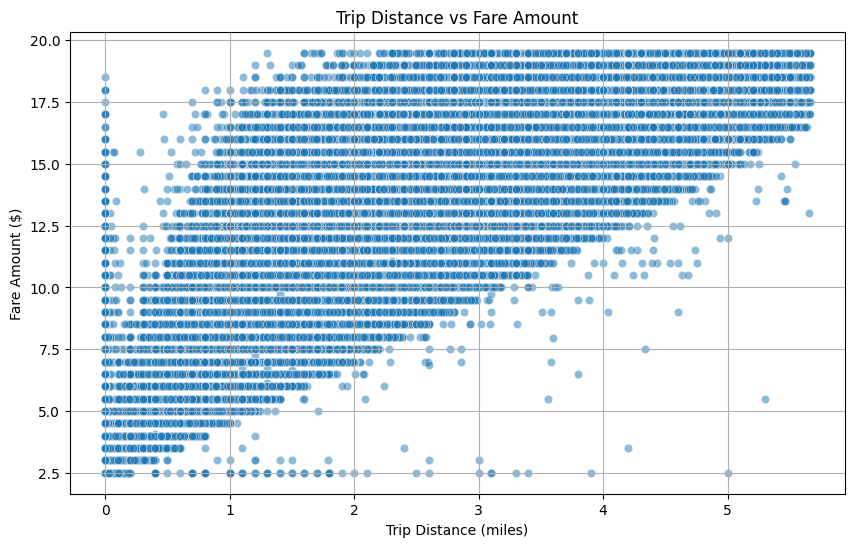

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pandas_df, x='trip_distance', y='fare_amount', alpha=0.5)
plt.title('Trip Distance vs Fare Amount')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.grid()
plt.show()


### Average Fare Amount Over Time

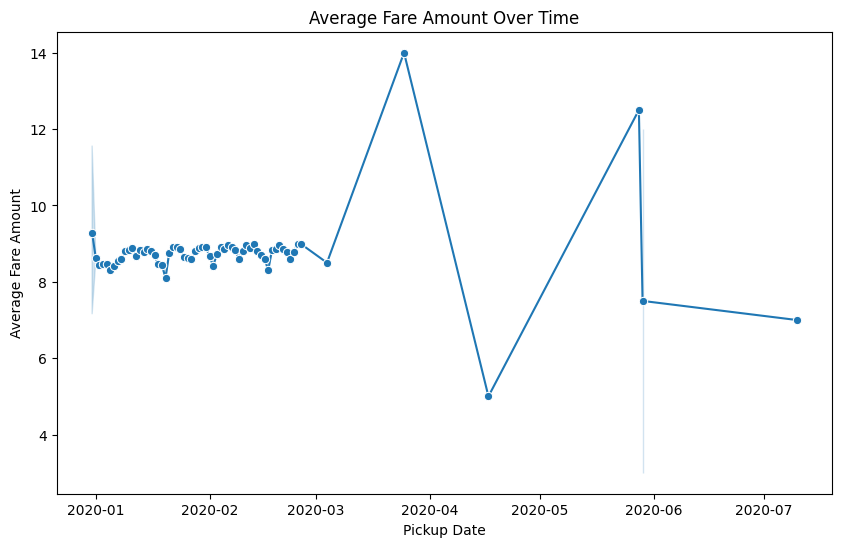

In [ ]:

plt.figure(figsize=(10, 6))
sns.lineplot(x=pandas_df['pickup_date'], y=pandas_df['fare_amount'], marker='o', linestyle='-')
plt.title("Average Fare Amount Over Time")
plt.xlabel("Pickup Date")
plt.ylabel("Average Fare Amount")
plt.savefig('Average Fare Amount Over Time.png')
plt.show()

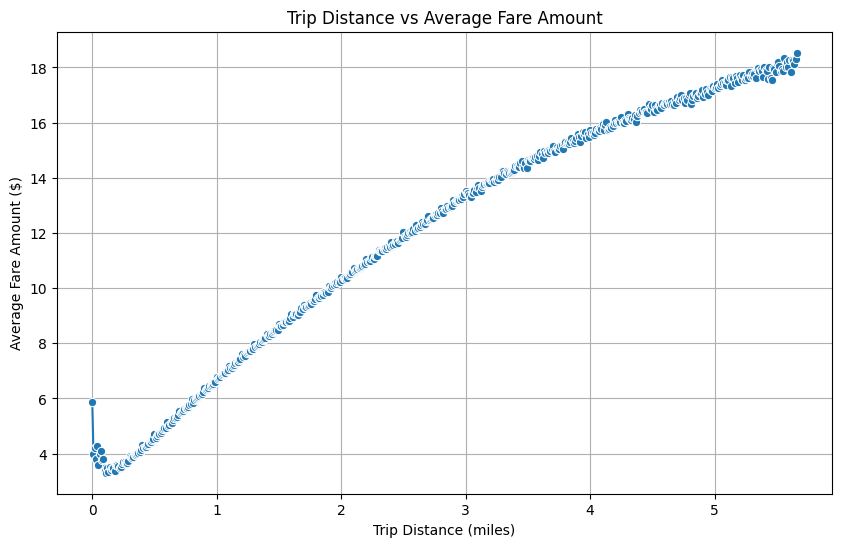

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group the data by 'trip_distance' and calculate the average fare_amount
lineplot_data = pandas_df.groupby('trip_distance', as_index=False)['fare_amount'].mean()

# Plot the line chart
plt.figure(figsize=(10, 6))
sns.lineplot(data=lineplot_data, x='trip_distance', y='fare_amount', marker='o', linestyle='-')
plt.title('Trip Distance vs Average Fare Amount')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Average Fare Amount ($)')
plt.grid()
plt.show()


### Passenger Count Distribution

C:\Users\manas\AppData\Local\Temp\ipykernel_18780\3848966601.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=distribution_df, x="passenger_count", y="count", palette="viridis")


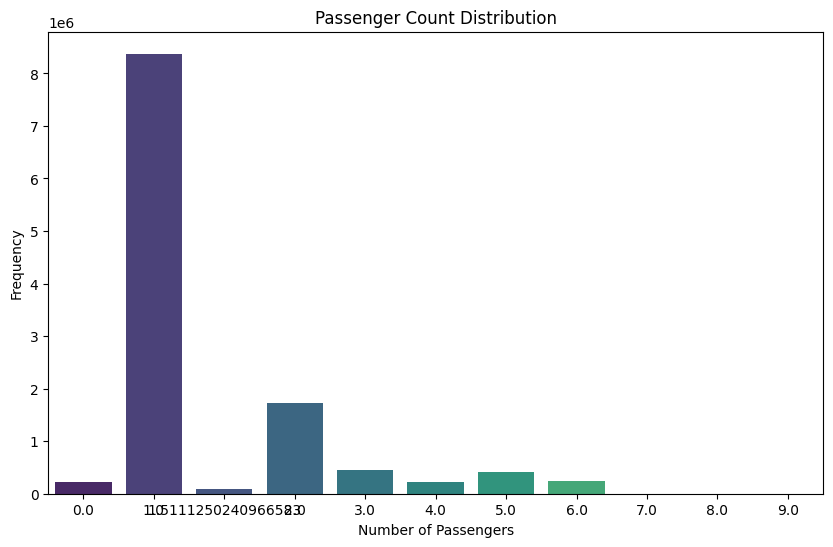

In [20]:
# Group by passenger_count and count occurrences
passenger_count_distribution = cleaned_data.groupBy("passenger_count") \
    .count() \
    .orderBy("passenger_count")

# Convert to Pandas DataFrame
distribution_df = passenger_count_distribution.toPandas()

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=distribution_df, x="passenger_count", y="count", palette="viridis")
plt.title("Passenger Count Distribution")
plt.xlabel("Number of Passengers")
plt.ylabel("Frequency")
plt.show()


### Correlation Matrix

In [66]:
from pyspark.sql.functions import col, isnan, isnull

# Check for null or NaN values
cleaned_data.filter(isnull(col("trip_duration")) | isnan(col("trip_duration"))).show()

# Check for negative or zero values (if trip duration must always be positive)
cleaned_data.filter(col("trip_duration") <= 0).show()

# Check for unusually large values
cleaned_data.select("trip_duration").orderBy(col("trip_duration").desc()).show(5)


+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+----------+-----------+----------+-----------+-----------+----------+------------+---------------------+-------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|PULatitude|PULongitude|DOLatitude|DOLongitude|pickup_hour|pickup_day|pickup_month|trip_duration_minutes|trip_duration|
+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+----------+-----------+----------+-----------

### Plot Pickup Location

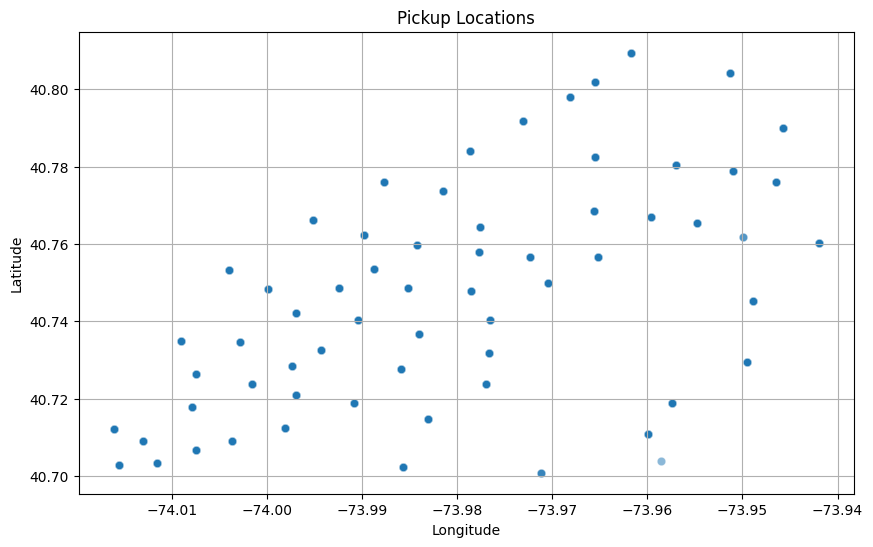

In [23]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pandas_df, x='PULongitude', y='PULatitude', alpha=0.3)
plt.title('Pickup Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()


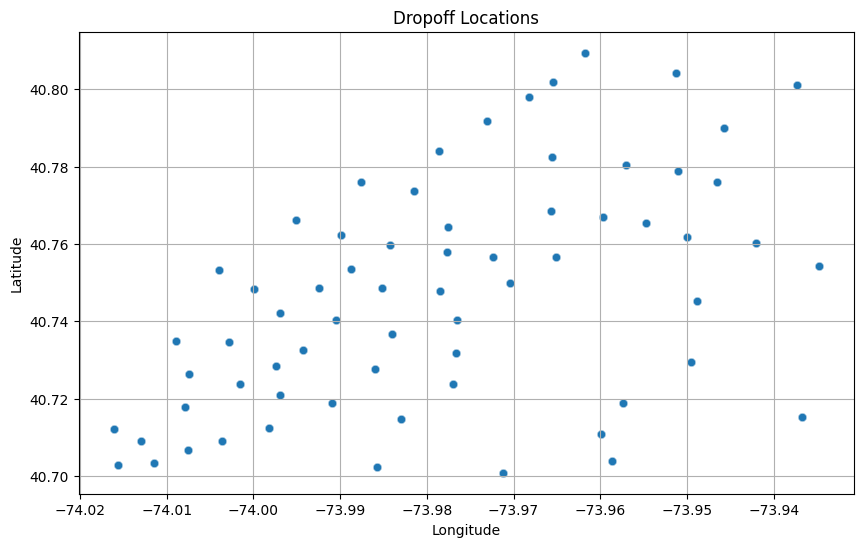

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pandas_df, x='DOLongitude', y='DOLatitude', alpha=0.3)
plt.title('Dropoff Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()


### Index Categorical Columns
Perform distributed indexing of categorical data:

In [40]:
from pyspark.ml.feature import StringIndexer

# Index categorical variables
ratecode_indexer = StringIndexer(inputCol="RatecodeID", outputCol="RatecodeID_index").fit(filtered_data)
filtered_data = ratecode_indexer.transform(filtered_data)

payment_indexer = StringIndexer(inputCol="payment_type", outputCol="payment_type_index").fit(data)
data = payment_indexer.transform(data)


### Assemble Feature Vector
Create a feature vector for the model:

In [42]:
from pyspark.ml.feature import VectorAssembler

feature_columns = [
    "passenger_count",
    "trip_distance",
    "RatecodeID_index",
    "PULocationID",
    "DOLocationID",
    "payment_type",
    "extra",
    "tip_amount",
    "tolls_amount",
    "congestion_surcharge",
]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
filtered_data = assembler.transform(filtered_data)


In [43]:
# Drop the existing features column
filtered_data = filtered_data.drop("features")

# Create the new VectorAssembler
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform the filtered_dataset
updated_filtered_data = vector_assembler.transform(filtered_data)

In [56]:
updated_filtered_data.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = false)
 |-- trip_distance: double (nullable = false)
 |-- RatecodeID: double (nullable = false)
 |-- PULocationID: double (nullable = false)
 |-- DOLocationID: double (nullable = false)
 |-- payment_type: double (nullable = false)
 |-- fare_amount: double (nullable = false)
 |-- extra: double (nullable = false)
 |-- mta_tax: double (nullable = false)
 |-- tip_amount: double (nullable = false)
 |-- tolls_amount: double (nullable = false)
 |-- improvement_surcharge: double (nullable = false)
 |-- total_amount: double (nullable = false)
 |-- congestion_surcharge: double (nullable = false)
 |-- PULatitude: double (nullable = false)
 |-- PULongitude: double (nullable = false)
 |-- DOLatitude: double (nullable = false)
 |-- DOLongitude: double (nullable = false)
 |-- RatecodeID_index: double (nulla

### Split Data into Batches
Split the data for distributed training and testing:


In [46]:
train, test = updated_filtered_data.randomSplit([0.8, 0.2], seed=42)

In [10]:
data = data.na.drop(subset=["PULatitude", "PULongitude", "DOLatitude", "DOLongitude"])


##  Train Models in Parallel

### GBT (Gradient Boosted Trees)

In [47]:
from pyspark.ml.regression import GBTRegressor

# Train GBT model in parallel
gbt = GBTRegressor(featuresCol="features", labelCol="fare_amount", maxIter=10)
gbt_model = gbt.fit(train)

# Make predictions on test data
gbt_predictions = gbt_model.transform(test)
gbt_predictions.select("fare_amount", "prediction").show(5)


+-----------+------------------+
|fare_amount|        prediction|
+-----------+------------------+
|        7.0| 7.769509025454572|
|        6.5| 7.235340742559401|
|        9.0|  8.59046269806387|
|       13.0|14.049127461957408|
|        7.0|7.3899868016650645|
+-----------+------------------+
only showing top 5 rows



### Random Forest

In [48]:
from pyspark.ml.regression import RandomForestRegressor

# Train Random Forest model
rf = RandomForestRegressor(featuresCol="features", labelCol="fare_amount", numTrees=50)
rf_model = rf.fit(train)

# Predict on test data
rf_predictions = rf_model.transform(test)
rf_predictions.select("fare_amount", "prediction").show(5)

+-----------+------------------+
|fare_amount|        prediction|
+-----------+------------------+
|        7.0| 8.223717800798518|
|        6.5| 7.355382420916234|
|        9.0| 8.373769367275266|
|       13.0|12.983235122360776|
|        7.0|7.3947063166806535|
+-----------+------------------+
only showing top 5 rows



### Decision Tree Regressor

In [49]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Create Decision Tree Regressor
dt = DecisionTreeRegressor(featuresCol="features", labelCol="fare_amount")

# Train the model
dt_model = dt.fit(train)

# Make predictions on the test set
dt_predictions = dt_model.transform(test)

In [50]:
dt_predictions.select("fare_amount", "prediction").show(5)

+-----------+-----------------+
|fare_amount|       prediction|
+-----------+-----------------+
|        7.0|7.879783243926905|
|        6.5|7.051096057260807|
|        9.0| 9.30900525863783|
|       13.0|13.39117685746375|
|        7.0|8.573598300460802|
+-----------+-----------------+
only showing top 5 rows



### Saving the Models and Evaluation

In [51]:
# Save models to HDFS or local file system
gbt_model.save("models2/gbt_model")
rf_model.save("models2/rf_model")
dt_model.save("models2/dt_model")


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate Gradient Boosted Trees
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")

gbt_rmse = evaluator.evaluate(gbt_predictions)
print(f"GBT RMSE: {gbt_rmse}")

# Similarly, evaluate Random Forest and Linear Regression
rf_rmse = evaluator.evaluate(rf_predictions)


# Similarly, evaluate Decision Tree
dt_rmse = evaluator.evaluate(dt_predictions)

print(f"DT RMSE: {dt_rmse}")



GBT RMSE: 1.254414860844439
DT RMSE: 1.3299540090040927


In [53]:
print(f"RF RMSE: {rf_rmse}")

RF RMSE: 1.4101098908482308


# Predictions

### Fare Amount Based On Pickup and Dropoff Zone

In [57]:
from pyspark.sql.functions import col, sum

# Use the Gradient Boosted Tree model to predict fare amounts
zone_predictions = gbt_model.transform(updated_filtered_data)

# Group by pickup zones and sum up predicted fare amounts
pickup_zone_analysis = zone_predictions.groupBy("PULocationID") \
    .agg(
        count("*").alias("trip_count"),
        sum("prediction").alias("total_predicted_revenue")
    ) \
    .orderBy(col("total_predicted_revenue").desc())

pickup_zone_analysis.show(10)

# Group by dropoff zones and sum up predicted fare amounts
dropoff_zone_analysis = zone_predictions.groupBy("DOLocationID") \
    .agg(
        count("*").alias("trip_count"),
        sum("prediction").alias("total_predicted_revenue")
    ) \
    .orderBy(col("total_predicted_revenue").desc())

dropoff_zone_analysis.show(10)

# Save results
pickup_zone_analysis.write.csv("output/pickup_zone_predictions.csv", header=True)
dropoff_zone_analysis.write.csv("output/dropoff_zone_predictions.csv", header=True)

+------------+----------+-----------------------+
|PULocationID|trip_count|total_predicted_revenue|
+------------+----------+-----------------------+
|       161.0|    321722|      2843294.578657855|
|       237.0|    343781|      2708498.563551627|
|       236.0|    325659|     2653335.5339250076|
|       162.0|    276251|      2442132.618674617|
|       186.0|    245985|      2266350.498507908|
|       234.0|    238088|      2051542.579357519|
|       230.0|    228509|     2019497.9500076803|
|       170.0|    228855|     1980734.9265826377|
|       142.0|    226533|      1954451.114466874|
|       163.0|    198044|      1737884.751604232|
+------------+----------+-----------------------+
only showing top 10 rows

+------------+----------+-----------------------+
|DOLocationID|trip_count|total_predicted_revenue|
+------------+----------+-----------------------+
|       236.0|    350779|      2887132.423474224|
|       237.0|    318725|     2501915.2861078656|
|       161.0|    290605

### Fare Amount Based Upon Distance and Hour Of The Day

In [60]:
from pyspark.sql.functions import hour, col, count, avg

# Add a column for the hour of pickup
updated_filtered_data = updated_filtered_data.withColumn("pickup_hour", hour(col("tpep_pickup_datetime")))

# Use the trained GBT model to predict fare amounts
distance_predictions = gbt_model.transform(updated_filtered_data)

# Group predictions by distance bucket and analyze fare
distance_pricing = distance_predictions.groupBy("distance_bucket") \
    .agg(
        count("*").alias("trip_count"),
        avg("prediction").alias("avg_predicted_fare")
    ) \
    .orderBy("distance_bucket")

distance_pricing.show()

# Save results
distance_pricing.write.csv("output/distance_pricing_with_predictions.csv", header=True)

# Analyze pricing by time of day
time_pricing = distance_predictions.groupBy("pickup_hour") \
    .agg(
        count("*").alias("trip_count"),
        avg("prediction").alias("avg_predicted_fare")
    ) \
    .orderBy("pickup_hour")

time_pricing.show()

# Save results
time_pricing.write.csv("output/time_pricing_with_predictions.csv", header=True)


+---------------+----------+------------------+
|distance_bucket|trip_count|avg_predicted_fare|
+---------------+----------+------------------+
|      0-2 miles|   4693509| 7.225427239292661|
|      2-5 miles|   1736888| 12.73995082748457|
|     5-10 miles|     24199|17.702019657658216|
+---------------+----------+------------------+

+-----------+----------+------------------+
|pickup_hour|trip_count|avg_predicted_fare|
+-----------+----------+------------------+
|          0|    158100| 8.989023824398489|
|          1|    118002|  9.03777961536558|
|          2|     85812| 9.070264707501304|
|          3|     54035| 9.091294871820407|
|          4|     29814| 9.068768194847461|
|          5|     36812| 8.554392244973513|
|          6|    115277| 8.986845124124118|
|          7|    254573| 8.897045038712609|
|          8|    335065| 8.645813881948271|
|          9|    324680| 8.603036339630224|
|         10|    302507| 8.614908455755195|
|         11|    313421|  8.60466267553588|
|  

In [64]:
from pyspark.sql.functions import hour, avg, count
from pyspark.ml.evaluation import RegressionEvaluator

# Predict fare amounts for each hour using the Gradient Boosted Trees model
hourly_predictions = updated_filtered_data.withColumn("pickup_hour", hour("tpep_pickup_datetime"))

# Use the trained GBT model to predict fare amounts
hourly_predictions = gbt_model.transform(hourly_predictions)

# Group predictions by hour to analyze trip counts and fare amounts
hourly_analysis = hourly_predictions.groupBy("pickup_hour") \
    .agg(
        count("*").alias("trip_count"),
        avg("prediction").alias("avg_predicted_fare")
    ) \
    .orderBy("pickup_hour")

hourly_analysis.show()

# Save the result for reporting purposes
hourly_analysis.write.csv("output/hourly_analysis_with_predictions.csv", header=True)

+-----------+----------+------------------+
|pickup_hour|trip_count|avg_predicted_fare|
+-----------+----------+------------------+
|          0|    158100| 8.989023824398489|
|          1|    118002|  9.03777961536558|
|          2|     85812| 9.070264707501304|
|          3|     54035| 9.091294871820407|
|          4|     29814| 9.068768194847461|
|          5|     36812| 8.554392244973513|
|          6|    115277| 8.986845124124118|
|          7|    254573| 8.897045038712609|
|          8|    335065| 8.645813881948271|
|          9|    324680| 8.603036339630224|
|         10|    302507| 8.614908455755195|
|         11|    313421|  8.60466267553588|
|         12|    339089| 8.566529514251952|
|         13|    336896| 8.588325928340995|
|         14|    354632| 8.599437160594768|
|         15|    365063| 8.607823340927952|
|         16|    348422| 8.647614634460592|
|         17|    418211| 8.742083089197802|
|         18|    473757| 8.789643993353861|
|         19|    427655| 8.86361